In [37]:
import cv2
import mediapipe as mp
import os
import numpy as np

In [2]:
pwd


'f:\\Computer Vision\\MediaPipe'

In [3]:
Data_dir = "American_sign_data"
if not os.path.exists(Data_dir):
    os.makedirs(Data_dir)

In [4]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils

number_of_classes = 4
number_of_photos_for_every_class = 100
Data_dir = 'American_sign_data'
cap = cv2.VideoCapture(0)

for j in range(number_of_classes):
    # Create directories for saving images
    if not os.path.exists(os.path.join(Data_dir, str(j))):
        os.makedirs(os.path.join(Data_dir, str(j)))
    print(f"Collecting the data for the {j} folder.")
    
    # Show the ready screen
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        else:
            frame = cv2.resize(frame, (1100, 700))
            cv2.putText(frame, ("Ready for collection, click q button :)"), (10, 50), cv2.FONT_HERSHEY_COMPLEX, 1.3, [255, 0, 0], 2)
            cv2.imshow("Collect data", frame)
            if cv2.waitKey(1) == ord("q"):
                break

    counter = 0      
    while counter < number_of_photos_for_every_class:
        ret, frame = cap.read()
        if not ret:
            break
        else:
            frame = cv2.resize(frame, (700, 500))
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)

            h, w, _ = frame.shape
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                    
                    # Create a blank image and draw the landmarks
                    C_image = np.zeros([h, w, 3], dtype=np.uint8)
                    mp_draw.draw_landmarks(C_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                    
            else:
                print("No hands detected.")

            cv2.imshow("Collect data", frame)
            cv2.waitKey(25)
            cv2.imwrite(os.path.join(Data_dir, str(j), f"{counter}.jpg"), C_image)
            counter += 1

cap.release()
cv2.destroyAllWindows()


### Train a CNN model for classfication

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import cv2
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split


# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard  
from tensorflow.keras.utils import normalize
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.metrics import Precision
# metrics
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
train_path = r'F:\Computer Vision\MediaPipe\American_sign_data'

Categories = [Class for Class in os.listdir(train_path)]

train_data = []

for category in Categories:
    label = Categories.index(category)
    path = os.path.join(train_path, category)
    for img in os.listdir(path):
        image = os.path.join(path, img)
        try:
            the_img = cv2.imread(image, 0)
            the_img = cv2.resize(the_img, (500, 500))
            train_data.append([the_img, label])
        except Exception as ex:
            pass

In [9]:
# On The Train Data
X = []
y = []

for features, labels in train_data:
    X.append(features)
    y.append(labels)
    
X = np.array(X) # Features
y = np.array(y) # Targets

In [10]:
# Split To Train and Validation
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.13, random_state=42, shuffle=True)

In [11]:
# shapes
print(f"X_train shape is {X_train.shape}")
print(f"y_train shape is {y_train.shape}")
print(f"X_test shape is {X_test.shape}")
print(f"y_test shape is {y_test.shape}")

X_train shape is (348, 500, 500)
y_train shape is (348,)
X_test shape is (52, 500, 500)
y_test shape is (52,)


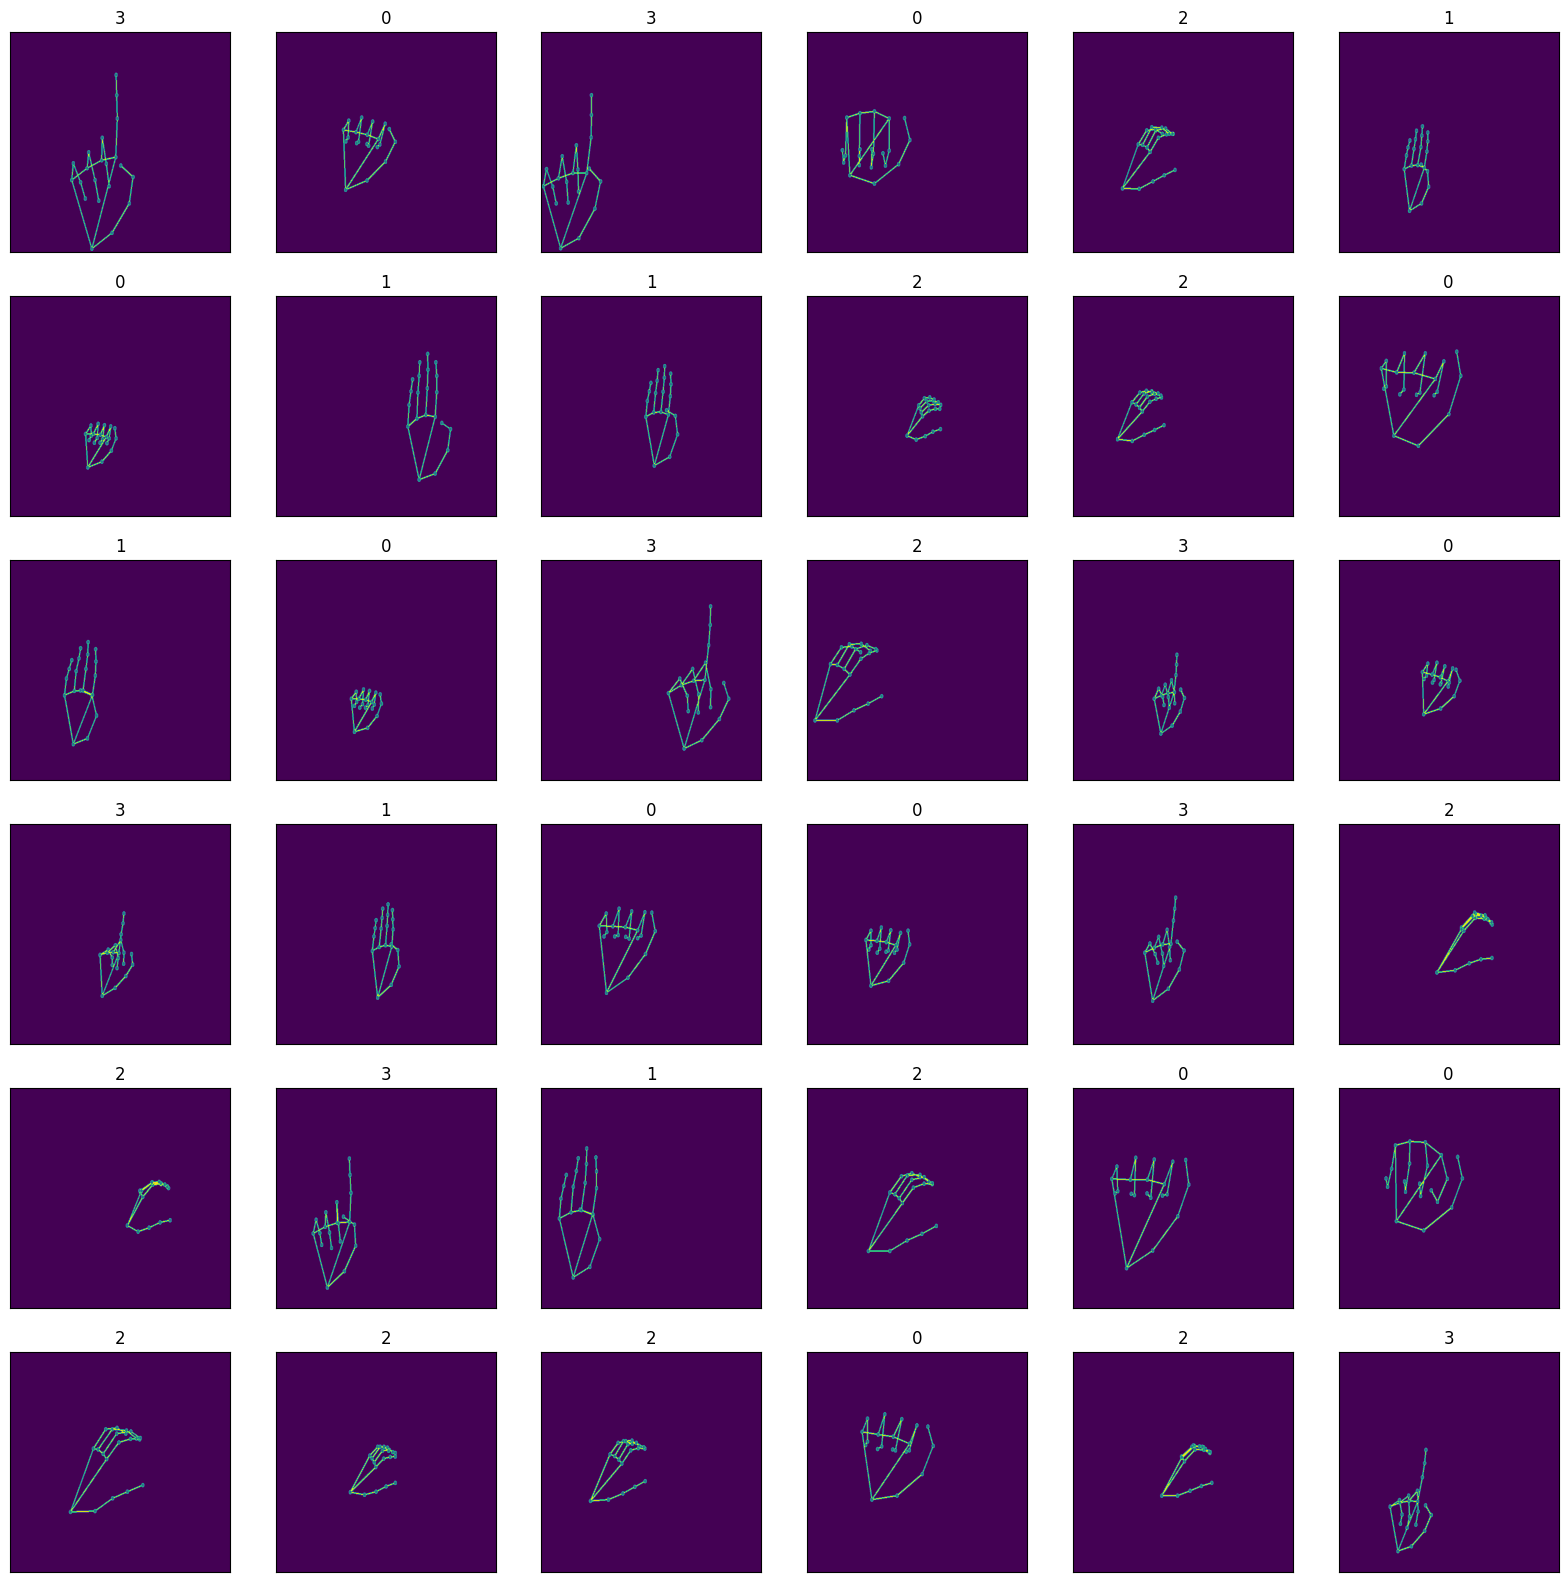

In [12]:
plt.figure(figsize=(20, 20))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(X_train[i])
    plt.title(f"{Categories[y_train[i]]}")
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [13]:
# make the range of piexls between 0 & 1
X_train = normalize(X_train)
X_test = normalize(X_test)

In [21]:
X_train[0].shape

(500, 500)

In [22]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(500, 500, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax'),
])

In [23]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [24]:

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16)

Epoch 1/50


22/22 [==============================] - 79s 3s/step - loss: 1.3383 - accuracy: 0.4914
Epoch 2/50
22/22 [==============================] - 91s 4s/step - loss: 0.8534 - accuracy: 0.7385
Epoch 3/50
22/22 [==============================] - 82s 4s/step - loss: 0.4567 - accuracy: 0.8276
Epoch 4/50
22/22 [==============================] - 73s 3s/step - loss: 0.2452 - accuracy: 0.9224
Epoch 5/50
22/22 [==============================] - 71s 3s/step - loss: 0.1942 - accuracy: 0.9195
Epoch 6/50
22/22 [==============================] - 67s 3s/step - loss: 0.0966 - accuracy: 0.9598
Epoch 7/50
22/22 [==============================] - 66s 3s/step - loss: 0.0597 - accuracy: 0.9885
Epoch 8/50
22/22 [==============================] - 67s 3s/step - loss: 0.0928 - accuracy: 0.9713
Epoch 9/50
22/22 [==============================] - 70s 3s/step - loss: 0.0610 - accuracy: 0.9885
Epoch 10/50
22/22 [==============================] - 68s 3s/step - loss: 0.0294 - accuracy: 0.9885
Epoch 11/50
22/22

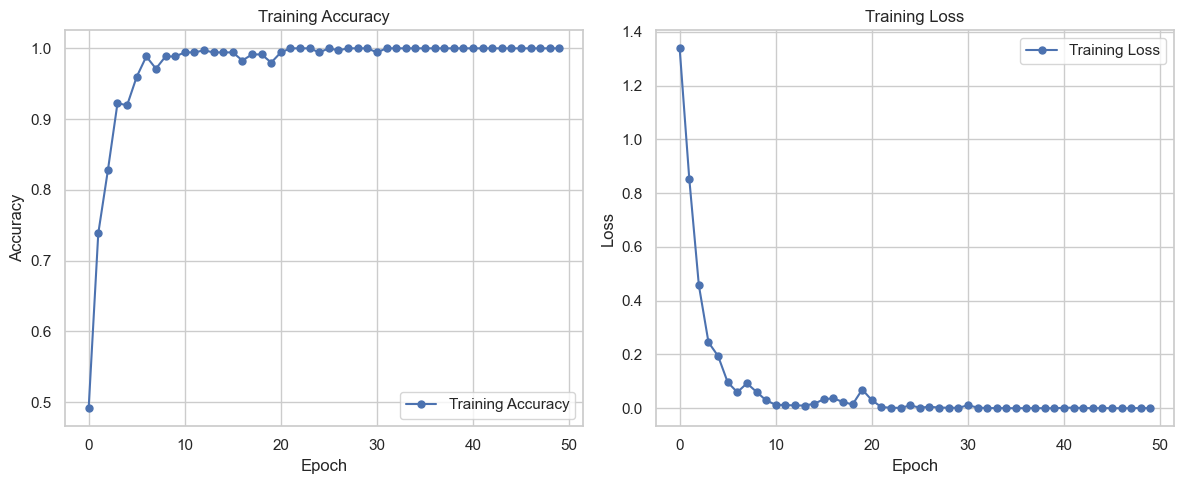

In [25]:
# The style
sns.set(style='whitegrid')

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

2/2 [==============================] - 3s 697ms/step - loss: 0.0647 - accuracy: 0.9808
Test Accuracy: 98.08%
Test Loss: 0.0647


In [27]:
# The Prediction
prediction = model.predict(X_test)
prediction


2/2 [==============================] - 2s 619ms/step


array([[8.90613213e-13, 2.84287180e-16, 1.00000000e+00, 1.26534321e-16],
       [3.11168202e-09, 1.17830616e-15, 1.00000000e+00, 7.67402255e-17],
       [9.99973536e-01, 3.18227306e-10, 2.64548689e-05, 4.49657645e-13],
       [1.08585580e-12, 9.99747826e-17, 1.00000000e+00, 5.47985914e-17],
       [9.99953747e-01, 7.75897124e-09, 4.62097269e-05, 2.72184636e-14],
       [9.99980092e-01, 4.03154168e-08, 1.98555863e-05, 2.17034168e-11],
       [5.21465128e-11, 5.45035739e-10, 5.36381107e-14, 1.00000000e+00],
       [9.99774873e-01, 2.89799029e-09, 2.25168900e-04, 8.11281296e-15],
       [1.37721898e-12, 7.35125916e-18, 1.00000000e+00, 1.60872417e-22],
       [1.89016136e-09, 9.99991894e-01, 2.17723986e-20, 8.09147514e-06],
       [9.99990463e-01, 7.41009032e-10, 9.58022065e-06, 1.05836140e-09],
       [2.14560973e-08, 1.48174539e-08, 3.30096853e-11, 1.00000000e+00],
       [9.99999404e-01, 7.93353161e-10, 6.45983732e-07, 3.44258840e-17],
       [9.99981642e-01, 2.82971624e-09, 1.83426309e

In [28]:
predictions = []
for i in range(len(prediction)):
    predictions.append(np.argmax(prediction[i]))
print(predictions[:20])

[2, 2, 0, 2, 0, 0, 3, 0, 2, 1, 0, 3, 0, 0, 1, 0, 2, 3, 2, 3]


In [32]:
len(predictions)

52

In [33]:
print("\033[1mThe Classification Report on Test Data\033[0m\n")
classification_rep = classification_report(y_test, predictions)
print(classification_rep)

The Classification Report on Test Data

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.92      1.00      0.96        12
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        11

    accuracy                           0.98        52
   macro avg       0.98      0.99      0.98        52
weighted avg       0.98      0.98      0.98        52



In [34]:
# Save the model (entire model: weights, architecture, and optimizer)
model.save('cnn_model.h5')

f:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### make prediction in the real time

In [35]:
# Load the model
loaded_model = tf.keras.models.load_model('cnn_model.h5')


In [41]:
import numpy as np
import cv2
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    else:
        frame = cv2.resize(frame, (500, 500))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w, _ = frame.shape
        results = hands.process(frame)
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                C_image = np.zeros([h, w, 3], dtype=np.uint8)
                mp_draw.draw_landmarks(C_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                C_image = cv2.cvtColor(C_image, cv2.COLOR_RGB2GRAY)
                C_image = np.expand_dims(C_image, axis=-1)  
                C_image = np.expand_dims(C_image, axis=0)   
                C_image = C_image.astype(np.float32) / 255.0
                prediction = loaded_model.predict(C_image)
                prediction = np.argmax(prediction)
                cv2.putText(frame, f"{prediction}", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 1.3, [255, 0, 0], 2)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imshow("Frame", frame)
        
        if cv2.waitKey(1) == 27:
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 68ms/step


f:\Anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 82ms/step
